# Main program GAIA-NIR

## Purpose

The main program handles the overall simulation flow by calling methods from the Spectrum and Parameters classes.\
The Spectrum class encapsulates all spectrum-related operations, including loading, processing, and saving the spectrum. \
The Parameters class handles configuration.


## Version History
- **v5.0**: Update: 

- Implemented energy conservation check and edge handling in convolution.


Last Edited: 2025-02-07


## Flowchart of first overview of program

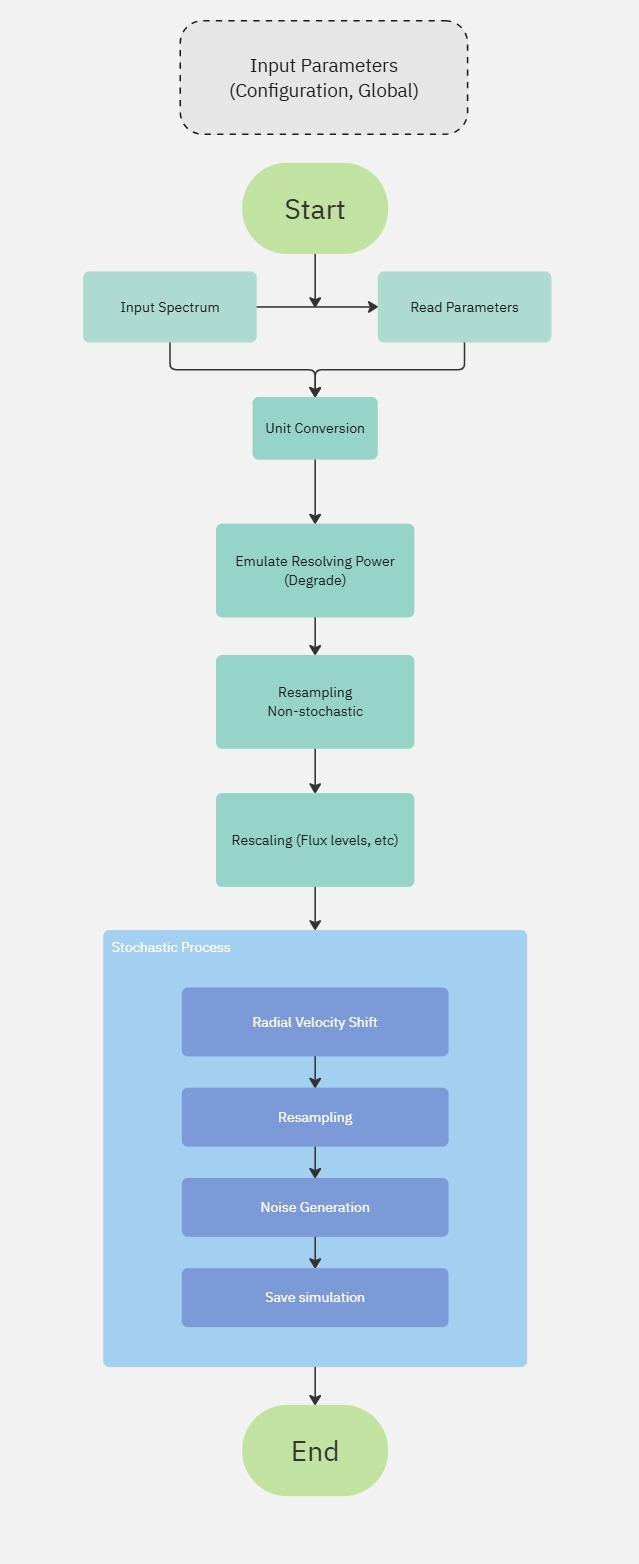

## Main program


In [1]:
# IMPROT CLASSES OR OTHER NECESSARY FILES
import import_ipynb
import numpy as np
from spectrum import Spectrum
from parameters import Parameters


In [3]:
import os
print(os.getcwd()) 

C:\Users\Mj\Documents\Internship\GAIA_NIR


Documents\Internship\GAIA_NIR\gaia_simulation_main

Initializing default parameters
Loading spectrum from gaia_055000450000.txt
Spectrum loaded correctly.
Reference spectrum saved.
Resampling and convolution completed.
Flux before convolution: 1887600.130156
Flux after convolution: 1885815.869977
Flux conservation ratio: 0.999055


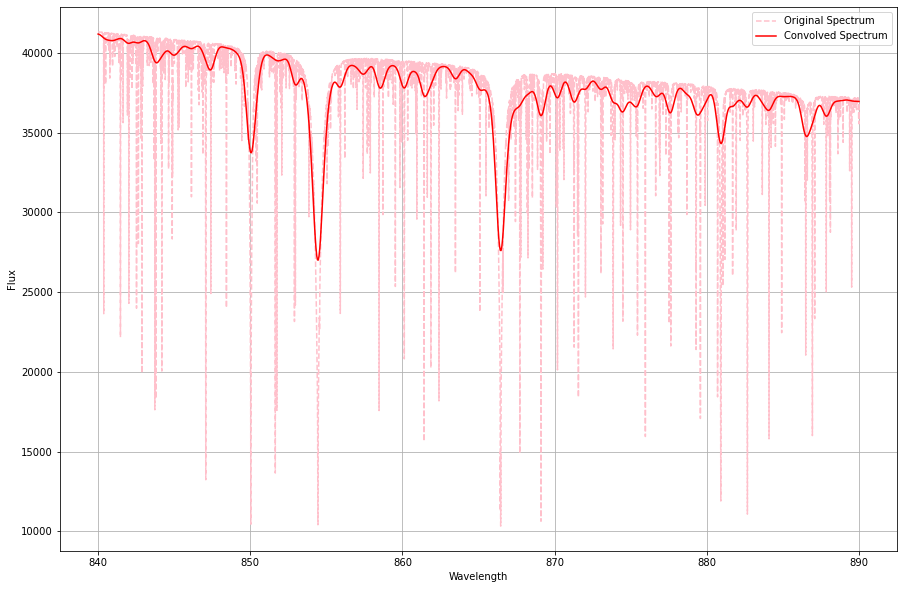

Applying radial velocity shift
Resampling spectrum for stochastic process
Adding noise to spectrum
Saving spectrum to output_spectrum_001.txt
Saving spectrum to output_spectrum_002.txt
Saving spectrum to output_spectrum_003.txt
Simulation complete.


In [2]:
def main():
    """
    Main function to control the simulation flow.
    """
    params = Parameters()
    spectrum = Spectrum()

    
    spectrum.load_spectrum("gaia_055000450000.txt")

    spectrum.resample_and_convolve().plot_comparison()
    

    for i in range(params.num_output_spectra):
        # Print once for test, change to True to print always
        spectrum.radial_velocity_shift(verbose=(i == 0))  
        spectrum.resample_stochastic(verbose=(i == 0))  
        spectrum.generate_noise(verbose=(i == 0))  
        spectrum.save_spectrum(output_file=f"output_spectrum_{i+1:03d}.txt")

    print("Simulation complete.")

if __name__ == "__main__":
    main()
